# Sales Prediction

Given historical sales data from from January 2013 to October 2015 of certain items (item_id) in certain shops (shop_id), forecast the sales for November 2015.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from seaborn import objects as so

In [2]:
item_categories = pd.read_csv("data/item_categories.csv")
print("item categories")
display(item_categories.head())
items = pd.read_csv("data/items.csv")
print("items ")
display(items.head())
sales_train = pd.read_csv("data/sales_train.csv")
print("train set")
display(sales_train.head())
shops = pd.read_csv("data/shops.csv")
print("shops ")
display(shops.head())

# for later
print("test data")
test = pd.read_csv("data/test.csv")
display(test.head())
sample_submission = pd.read_csv("data/sample_submission.csv")
print("submission test")
display(sample_submission.head())

item categories


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


items 


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


train set


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


shops 


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


test data


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


submission test


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


### Save some memory adjusting types

In [3]:
display(sales_train.shape)
display(sales_train.describe())
display(sales_train.dtypes)
initial_mem_usage = sales_train.memory_usage(deep = True).sum()
sales_train =  sales_train.assign(
        date = pd.to_datetime(sales_train.date, format='%d.%m.%Y'),
        date_block_num = sales_train.date_block_num.astype('int8'),
        shop_id = sales_train.shop_id.astype('int8')
    )
print(f"saved {(initial_mem_usage - sales_train.memory_usage(deep=True).sum())/initial_mem_usage*100:.2f}%")

(2935849, 6)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

saved 68.22%


In [4]:
items.describe()
items = items.assign(item_category_id = items.item_category_id.astype('int8'))

### Join item categories with train set

In [5]:
sales_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [9]:
# grouping for month
features = ['shop_id', 'item_id', 'item_price', 'item_cnt_day']

train_joined = (sales_train[features + ['date_block_num', 'date']]
                .join(items[['item_id', 'item_category_id']],
                       on='item_id', how = 'inner', rsuffix='_other')
            .assign(
                is_year_start = lambda x:x['date'].dt.is_year_start,
                is_year_end = lambda x:x['date'].dt.is_year_end
            )            
                .drop(columns=['item_id_other', 'date'])
            .groupby(['date_block_num', 'is_year_start', 'is_year_end', 
                      'shop_id', 'item_id', 'item_price', 'item_category_id'])
            .sum()
            .reset_index()
            .drop(columns=['date_block_num'])
            .rename(columns={'item_cnt_day':'item_cnt_month'})
)
display(train_joined)

,is_year_start,is_year_end,shop_id,item_id,item_price,item_category_id,item_cnt_month
0,False,False,0,32,221.0,40,6.0
1,False,False,0,33,347.0,37,3.0
2,False,False,0,35,247.0,40,1.0
3,False,False,0,43,221.0,40,1.0
4,False,False,0,51,127.0,57,1.0
...,...,...,...,...,...,...,...
1752864,False,False,59,22087,119.0,83,6.0
1752865,False,False,59,22088,119.0,83,2.0
1752866,False,False,59,22091,179.0,83,1.0
1752867,False,False,59,22100,629.0,42,1.0


In [10]:
print(f"number of different shops {train_joined['shop_id'].nunique()}")
print(f"number of different items {train_joined['item_id'].nunique()}")
print(f"different item categories {train_joined['item_category_id'].nunique()}")

number of different shops 60
number of different items 21807
different item categories 84


In [11]:
# distribution of observation per item
train_joined['item_id'].value_counts().describe()

count    21807.000000
mean        80.381024
std        155.480655
min          1.000000
25%          5.000000
50%         27.000000
75%         91.000000
max       7493.000000
Name: count, dtype: float64

## Fitting BART model
The advantage of using BART is its capability of handling high cardinality categorical features without increasing the problem dimensionality.

In [13]:
train_joined['item_id'].value_counts().sort_values(ascending=False).head(10)

item_id
17717    7493
7893     2051
2445     2008
4244     1970
6675     1900
4248     1864
6457     1851
7894     1842
6497     1818
4249     1805
Name: count, dtype: int64

<Axes: >

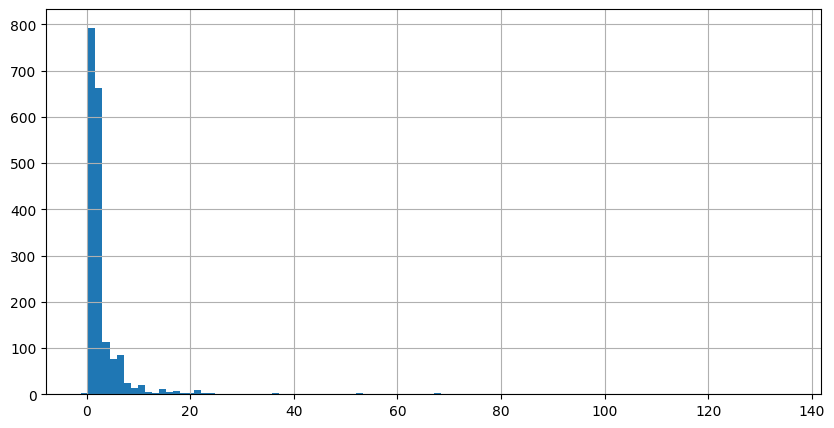

In [28]:
# visualizing distribution of item_cnt_month for a set of items
items_to_plot = train_joined['item_id'].value_counts().sort_values(ascending=False).head(20).index
train_joined.loc[train_joined['item_id'] == items_to_plot[6], 'item_cnt_month'].hist(bins = 100, figsize=(10,5))

initial quantiles


count    1.752869e+06
mean     2.081277e+00
std      7.517894e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.169000e+03
Name: item_cnt_month, dtype: float64

<Figure size 1000x500 with 0 Axes>

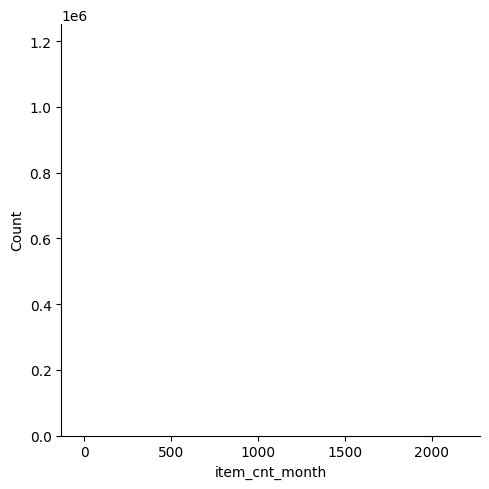

Standard Scaling


count    1.752869e+06
mean    -2.646189e-17
std      1.000000e+00
min     -3.203195e+00
25%     -1.438271e-01
50%     -1.438271e-01
75%     -1.081115e-02
max      2.882348e+02
Name: item_cnt_month, dtype: float64

KeyboardInterrupt: 

In [34]:
from sklearn.preprocessing import StandardScaler, RobustScaler

print("initial quantiles")
display(train_joined['item_cnt_month'].describe())
plt.figure(figsize=(10,5))
sns.displot(train_joined['item_cnt_month'])
plt.show()
# Standard Scaling
print("Standard Scaling")
display(((train_joined['item_cnt_month'] - train_joined['item_cnt_month'].mean())/train_joined['item_cnt_month'].std()).describe())
plt.figure(figsize=(10,5))
sns.displot((train_joined['item_cnt_month'] - train_joined['item_cnt_month'].mean())/train_joined['item_cnt_month'].std())
plt.show()
print("Robust Scaling")
display(((train_joined['item_cnt_month'] - train_joined['item_cnt_month'].median())/train_joined['item_cnt_month'].quantile(0.75)).describe())

plt.figure(figsize=(10,5)) 
sns.displot((train_joined['item_cnt_month'] - train_joined['item_cnt_month'].median())/train_joined['item_cnt_month'].quantile(0.75))
plt.show()

In [29]:
train_joined.columns

Index(['is_year_start', 'is_year_end', 'shop_id', 'item_id', 'item_price',
       'item_category_id', 'item_cnt_month'],
      dtype='object')

In [ ]:
import pymc as pm
import pymc_bart as pmb
split_rules = [
    pmb.OneHotSplitRule(),#is_year_start
    pmb.OneHotSplitRule(),#is_year_end
    pmb.OneHotSplitRule(),#shop_id
    pmb.SubsetSplitRule(),#item_id
    pmb.ContinuousSplitRule(),#item_price
    pmb.OneHotSplitRule(),#item_category_id
]


with pm.Model() as model:
    bart_variable =  pmb.BART('bart', 
                              X=train_joined.drop(columns=['item_cnt_month']),
                                y=train_joined['item_cnt_month'],
                                split_rules=split_rules,
                              
                              data=train_joined)

    trace = pm.sample(1000, tune=1000)

### Fitting classical ML regression models

Regressing items per day versus all other features. The problem is that the categorical variables are high cardinality.

In [10]:
# from sklearn.model_selection import KFold
# from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
# from sklearn.metrics import mean_squared_error

# metrics = {
#     'rmse': lambda y_true, y_pred: np.sqrt(np.mse(y_true, y_pred)),
#     'mse': np.mse(y_true, y_pred),
#     'mae': lambda y_true, y_pred: np.mean(np.abs(y_true - y_pred))
#     'mape': lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred)/y_true))
# }

# models = {
#     'rf': RandomForestRegressor(n_estimators=100, n_jobs=-1),
#     'et': ExtraTreesRegressor(n_estimators=100, n_jobs=-1)
# }

# for model_name, model in models.items():
#     print(f"training {model_name}")
#     kf = KFold(n_splits=3, shuffle=True)
#     for train_index, test_index in kf.split(train_joined):
#         X_train, X_test = train_joined.iloc[train_index], train_joined.iloc[test_index]
#         y_train, y_test = X_train.pop('item_cnt_day'), X_test.pop('item_cnt_day')
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         print(f"rmse {metrics['rmse'](y_test, y_pred)}")
#         print(f"mse {metrics['mse'](y_test, y_pred)}")
#         print(f"mae {metrics['mae'](y_test, y_pred)}")
#         print(f"mape {metrics['mape'](y_test, y_pred)}")
#         print("")

RMSE: 6.70
